# Import Libraries

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from apyori import apriori
import networkx as nx 
import netgraph
import plotly.graph_objects as go
sns.set_theme(style="whitegrid", palette='Set2')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import Data

In [36]:
df = pd.read_csv('../../data/02-model-data/data_cleaned.csv')
df.head()

,season,round,season_round,driverId,raceId,circuitId,position,points,grid,laps,...,weather,stop,age_on_race,cumulative_points,cumulative_laps,pole_driverId,pole_history,win_driverId,win_history,label
0,1950,1,1950_1,642,833,9,1,9.0,1,70,...,Fine,Not Available,44,9.0,70,642,1,642,1,Podium
1,1950,1,1950_1,786,833,9,2,6.0,2,70,...,Fine,Not Available,52,6.0,70,642,0,642,0,Podium
2,1950,1,1950_1,686,833,9,3,4.0,4,70,...,Fine,Not Available,39,4.0,70,642,0,642,0,Podium
3,1950,1,1950_1,704,833,9,4,3.0,6,68,...,Fine,Not Available,46,3.0,68,642,0,642,0,Top_10
4,1950,1,1950_1,627,833,9,5,2.0,9,68,...,Fine,Not Available,45,2.0,68,642,0,642,0,Top_10


In [37]:
driver_df = pd.read_csv('../../data/00-raw-data/drivers.csv')
driver_df.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [38]:
df = pd.merge(df, driver_df[['driverId', 'driverRef']], on='driverId', how='left')
driver_df.rename(columns={'driverId':'pole_driverId'}, inplace=True)
df = pd.merge(df, driver_df[['pole_driverId', 'driverRef']], on='pole_driverId', how='left')
driver_df.rename(columns={'pole_driverId':'win_driverId'}, inplace=True)
df = pd.merge(df, driver_df[['win_driverId', 'driverRef']], on='win_driverId', how='left')
df.rename(columns={'driverRef_x':'driverRef', 'driverRef_y':'pole_driverRef', 'driverRef':'win_driverRef'}, inplace=True)
df.head()

,season,round,season_round,driverId,raceId,circuitId,position,points,grid,laps,...,cumulative_points,cumulative_laps,pole_driverId,pole_history,win_driverId,win_history,label,driverRef,pole_driverRef,win_driverRef
0,1950,1,1950_1,642,833,9,1,9.0,1,70,...,9.0,70,642,1,642,1,Podium,farina,farina,farina
1,1950,1,1950_1,786,833,9,2,6.0,2,70,...,6.0,70,642,0,642,0,Podium,fagioli,farina,farina
2,1950,1,1950_1,686,833,9,3,4.0,4,70,...,4.0,70,642,0,642,0,Podium,reg_parnell,farina,farina
3,1950,1,1950_1,704,833,9,4,3.0,6,68,...,3.0,68,642,0,642,0,Top_10,cabantous,farina,farina
4,1950,1,1950_1,627,833,9,5,2.0,9,68,...,2.0,68,642,0,642,0,Top_10,rosier,farina,farina


In [39]:
df.columns

Index(['season', 'round', 'season_round', 'driverId', 'raceId', 'circuitId',
       'position', 'points', 'grid', 'laps', 'status', 'constructorRef',
       'weather', 'stop', 'age_on_race', 'cumulative_points',
       'cumulative_laps', 'pole_driverId', 'pole_history', 'win_driverId',
       'win_history', 'label', 'driverRef', 'pole_driverRef', 'win_driverRef'],
      dtype='object')

# Data Pre-Processing
- Taking our Record Cleaned Data from earlier stages, data preprocessing steps need to be performed.
- Some of them are:
    - Drop unnecessary columns.
    - Taking data from years 2016-2021.
    - Converting all columns to characters since we need texts to make a transaction data.
    - Finally converting our pandas dataframe to a transactional database (nested list data).

In [40]:
df.drop(['season_round', 'driverId', 'pole_driverId', 'win_driverId'], axis=1, inplace=True)
df.head()

,season,round,raceId,circuitId,position,points,grid,laps,status,constructorRef,...,stop,age_on_race,cumulative_points,cumulative_laps,pole_history,win_history,label,driverRef,pole_driverRef,win_driverRef
0,1950,1,833,9,1,9.0,1,70,Finished,alfa,...,Not Available,44,9.0,70,1,1,Podium,farina,farina,farina
1,1950,1,833,9,2,6.0,2,70,Finished,alfa,...,Not Available,52,6.0,70,0,0,Podium,fagioli,farina,farina
2,1950,1,833,9,3,4.0,4,70,Finished,alfa,...,Not Available,39,4.0,70,0,0,Podium,reg_parnell,farina,farina
3,1950,1,833,9,4,3.0,6,68,Lapped,lago,...,Not Available,46,3.0,68,0,0,Top_10,cabantous,farina,farina
4,1950,1,833,9,5,2.0,9,68,Lapped,lago,...,Not Available,45,2.0,68,0,0,Top_10,rosier,farina,farina


In [41]:
df = df[df['season'] != 2022]

In [42]:
df = df[df['season'] > 2015]

In [43]:
df.reset_index(drop=True, inplace=True)
df

,season,round,raceId,circuitId,position,points,grid,laps,status,constructorRef,...,stop,age_on_race,cumulative_points,cumulative_laps,pole_history,win_history,label,driverRef,pole_driverRef,win_driverRef
0,2016,1,948,1,1,25.0,2,57,Finished,mercedes,...,Two,31,1234.5,10014,22,15,Podium,rosberg,hamilton,rosberg
1,2016,1,948,1,2,18.0,1,57,Finished,mercedes,...,Two,31,1885.0,9375,50,43,Podium,hamilton,hamilton,rosberg
2,2016,1,948,1,3,15.0,3,57,Finished,ferrari,...,Three,29,1911.0,8633,46,42,Podium,vettel,hamilton,rosberg
3,2016,1,948,1,4,12.0,8,57,Finished,red_bull,...,Three,27,372.0,5007,0,3,Top_10,ricciardo,hamilton,rosberg
4,2016,1,948,1,5,10.0,6,57,Finished,williams,...,Two,35,1081.0,12729,16,11,Top_10,massa,hamilton,rosberg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,2021,22,1073,24,16,0.0,16,50,Accident,williams,...,One,26,7.0,2106,0,0,Outside_Top_10,latifi,max_verstappen,max_verstappen
2478,2021,22,1073,24,17,0.0,14,33,Mechanical_Issue,alfa,...,One,28,21.0,3416,0,0,Outside_Top_10,giovinazzi,max_verstappen,max_verstappen
2479,2021,22,1073,24,18,0.0,17,26,Mechanical_Issue,williams,...,Not Available,23,19.0,3233,0,0,Outside_Top_10,russell,max_verstappen,max_verstappen
2480,2021,22,1073,24,19,0.0,18,25,Mechanical_Issue,alfa,...,One,42,1873.0,18618,18,21,Outside_Top_10,raikkonen,max_verstappen,max_verstappen


In [44]:
df.drop(['raceId', 'circuitId', 'points', 'grid',
       'laps', 'cumulative_points', 'cumulative_laps', 'pole_history', 'win_history'], axis=1, inplace=True)

In [45]:
for i in range(len(df)):
    
    for col in df.columns:
        
        df[col][i] = col + '_' + str(df[col][i])

In [46]:
records = []
for i in range(len(df)):
    records.append([str(df.values[i,j]) for j in range(0, 12)])

# Association Rule Mining
- At this critical juncture, the dependency on data for driving business decisions has increased to a great extent. Data Mining is one such method that helps in decision making. It is the process of deriving trends, patterns, and useful information from a massive amount of data. The data mining process of discovering the rules that govern associations and causal objects between sets of items is known as Association Rule Mining. It helps in discovering relationships between databases that seem to be independent thus developing connections between datasets.
- `Association Rule Mining` (ARM) is a technique for identifying frequent patterns, correlations, associations, or causal structures in data sets found in a variety of databases, including relational databases, transactional databases, and other types of data repositories.
- Since most machine learning algorithms work with numerical datasets, they are mathematical in nature. But, Association Rule Mining is appropriate for non-numeric, categorical data and requires a little more than simple counting.
- Given a set of transactions, the goal of association rule mining is to find the rules that allow us to predict the occurrence of a specific item based on the occurrences of the other items in the transaction.
- An association rule consists of two parts:
    - an antecedent (if) and
    - a consequent (then)
- An antecedent is something found in data, and a consequent is something located in conjunction with the antecedent.
- `Basic Definitions:`
    - Support Count(σ):  It accounts for the frequency of occurrence of an itemset.<br>
    - Frequent Itemset: It represents an itemset whose support is greater than or equal to the minimum threshold.
    - Association Rule: It represents an implication expression of the form X -> Y. Here X and Y represent any 2 itemsets.<br>
    Example: {Milk, Diaper}->{Beer} 
- `Rule Evaluation Metrics:`
    - Support(s): It is the number of transactions that include items from the {X} and {Y} parts of the rule as a percentage of total transactions. It can be represented in the form of a percentage of all transactions that shows how frequently a group of items occurs together.
    - Support = σ(X+Y) ÷ total: It is a fraction of transactions that include both X and Y. 
    - Confidence(c): This ratio represents the total number of transactions of all of the items in {A} and {B} to the number of transactions of the items in {A}.
    - Conf(X=>Y) = Supp(X∪Y) ÷ Supp(X): It counts the number of times each item in Y appears in transactions that also include items in X.
    - Lift(l): The lift of the rule X=>Y is the confidence of the rule divided by the expected confidence. here, it is assumed that the itemsets X and Y are independent of one another. The expected confidence is calculated by dividing the confidence by the frequency of {Y}.
    - Lift(X=>Y) = Conf(X=>Y) ÷ Supp(Y): Lift values near 1 indicate that X and Y almost always appear together as expected. Lift values greater than 1 indicate that they appear together more than expected, and lift values less than 1 indicate that they appear less than expected. Greater lift values indicate a more powerful association.
- `Algorithms of Association Rule Mining:`
    - **Apriori Algorithm:**<br>
    It delivers by characteristic the foremost frequent individual things within the information and increasing them to larger and bigger item sets as long as those item sets seem ofttimes enough within the information. The common itemsets ensured by apriori also are accustomed make sure association rules that highlight trends within the information. It counts the support of item sets employing a breadth-first search strategy and a candidate generation perform that takes advantage of the downward closure property of support.
    - **Eclat Algorithm:**<br>
    Eclat denotes equivalence class transformation. The set intersection was supported by its depth-first search formula. It’s applicable for each successive and parallel execution with spot-magnifying properties. This can be the associate formula for frequent pattern mining supported by the item set lattice’s depth-first search cross.
        1. It is a DFS cross of the prefix tree rather than a lattice.
        2. For stopping, the branch and a specific technique are used.
    - **FP-growth Algorithm:**<br>
    This algorithm is also called a recurring pattern. The FP growth formula is used for locating frequent item sets terribly dealings data but not for candidate generation.
    This was primarily designed to compress the database that provides frequent sets and then divides the compressed data into conditional database sets.
    This conditional database is associated with a frequent set. Each database then undergoes the process of data mining.The data source is compressed using the FP-tree data structure.
    This algorithm operates in two stages. These are as follows:
        1. FP-tree construction
        2. Extract frequently used itemsets
- `Applications:`
    - Market-Basket Analysis:<br>
    In most supermarkets, data is collected using barcode scanners. This database is called the “market basket” database. It contains a large number of past transaction records. Every record contains the name of all the items each customer purchases in one transaction. From this data, the stores come to know the inclination and choices of items of the customers. And according to this information, they decide the store layout and optimize the cataloging of different items.
    - Medical Diagnosis:<br>
    Association rules in medical diagnosis can help physicians diagnose and treat patients. Diagnosis is a difficult process with many potential errors that can lead to unreliable results. You can use relational association rule mining to determine the likelihood of illness based on various factors and symptoms. This application can be further expanded using some learning techniques on the basis of symptoms and their relationships in accordance with diseases.
    - Census Data:<br>
    The concept of Association Rule Mining is also used in dealing with the massive amount of census data. If properly aligned, this information can be used in planning efficient public services and businesses. 
- `Drawbacks:`
    - A lengthy procedure of obtaining monotonous rules.
    - Having a large number of discovered rules.
    - Low performance of the Association Rule algorithms.
    - Consideration of a lot of parameters for obtaining the rules. 










## Apriori Algorithm
- There are 3 ways to measure association:
    - Support: It gives the fraction of transactions which contains item A and B. Basically Support tells us about the frequently bought items or the combination of items bought frequently. So with this, we can filter out the items that have a low frequency.
    $$Support = \frac {freq(A,B)}{N}$$
    - Confidence: It tells us how often the items A and B occur together, given the number times A occurs. Typically, when you work with the Apriori Algorithm, you define these terms accordingly. But how do you decide the value? Honestly, there isn’t a way to define these terms. Suppose you’ve assigned the support value as 2. What this means is, until and unless the item/s frequency is not 2%, you will not consider that item/s for the Apriori algorithm. This makes sense as considering items that are bought less frequently is a waste of time. Now suppose, after filtering you still have around 5000 items left. Creating association rules for them is a practically impossible task for anyone. This is where the concept of lift comes into play.
    $$Confidence = \frac {freq(A,B)}{freq(A)}$$
    - Lift: Lift indicates the strength of a rule over the random occurrence of A and B. It basically tells us the strength of any rule. Focus on the denominator, it is the probability of the individual support values of A and B and not together. Lift explains the strength of a rule. More the Lift more is the strength. Let’s say for A -> B, the lift value is 4. It means that if you buy A the chances of buying B is 4 times.
    $$Lift = \frac {Support}{Supp(A) * Supp(B)}$$
- Apriori algorithm uses frequent itemsets to generate association rules. It is based on the concept that a subset of a frequent itemset must also be a frequent itemset. Frequent Itemset is an itemset whose support value is greater than a threshold value(support).
- Given a threshold C, the Apriori algorithm identifies the item sets which are subsets of at least C transactions in the database.
- Apriori uses a "bottom up" approach, where frequent subsets are extended one item at a time (a step known as candidate generation), and groups of candidates are tested against the data. The algorithm terminates when no further successful extensions are found.
- Apriori uses breadth-first search and a Hash tree structure to count candidate item sets efficiently. It generates candidate item sets of length k from item sets of length k-1. Then it prunes the candidates which have an infrequent sub pattern. According to the downward closure lemma, the candidate set contains all frequent k-length item sets. After that, it scans the transaction database to determine frequent item sets among the candidates.
- `Steps of the Apriori algorithm:`
    1. Computing the support for each individual item.
    2. Deciding on the support threshold.
    3. Selecting the frequent items.
    4. Finding the support of the frequent itemsets.
    5. Repeat for larger sets.
    6. Generate Association Rules and compute confidence.
    7. Compute lift.


Running the apriori algorithm for min_support=0.05, min_confidence=0.2, min_lift=2, min_length=2 :

In [151]:
association_rules = apriori(records, min_support=0.05, min_confidence=0.2, min_lift=2, min_length=2)
association_results = list(association_rules)

Outputting the results:

In [154]:
for item in association_results:
    
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])
    
    #second index of the inner list
    print("Support: " + str(item[1]))
    
    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: constructorRef_mercedes -> label_Podium
Support: 0.06809024979854955
Confidence: 0.6926229508196721
Lift: 4.696967661023022
Rule: label_Podium -> status_Finished
Support: 0.14746172441579372
Confidence: 1.0
Lift: 2.135972461273666
Rule: pole_driverRef_leclerc -> season_2019
Support: 0.05640612409347301
Confidence: 0.7777777777777778
Lift: 4.596296296296296
Rule: season_2021 -> pole_driverRef_max_verstappen
Support: 0.08058017727639001
Confidence: 0.7692307692307693
Lift: 4.33916083916084
Rule: weather_Sunny -> pole_driverRef_max_verstappen
Support: 0.072522159548751
Confidence: 0.6923076923076923
Lift: 2.0263062409288826
Rule: pole_driverRef_max_verstappen -> win_driverRef_max_verstappen
Support: 0.072522159548751
Confidence: 0.6923076923076923
Lift: 4.274397244546498
Rule: season_2016 -> pole_driverRef_rosberg
Support: 0.07091055600322321
Confidence: 1.0
Lift: 5.372294372294372
Rule: win_driverRef_rosberg -> pole_driverRef_rosberg
Support: 0.0531829170024174
Confidence: 0.749999

### Helper Functions
- **reformat_results**: Reformats the results from the apriori algorithm into a dataframe with itemsets, support, confidence and lift values.
- **convert_to_network**: Converts the apriori dataframe into a Network Graph.
- **plot_network**: Visualisation of the Network Graph.

In [155]:
def reformat_results(results):

    #CLEAN-UP RESULTS 
    keep=[]
    for i in range(0,len(results)):
        for j in range(0,len(list(results[i]))):
            # print(results)
            if(j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        #print(len(results[i][j][k][0]),results[i][j][k][0])
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
                        # keep.append()
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

In [156]:
def convert_to_network(df):
    #print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

In [179]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.planar_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(45, 45)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    node_color='crimson',
    edgecolors="black",
    edge_color=colors_e,
    node_size=7000,
    linewidths=2,
    font_size=12,
    font_color="black",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set_title("NetworkX Graph for Association Rules", fontsize=50)
    
    plt.show()

# raise

### Final Reformatting and Plotting

In [158]:
result_df = reformat_results(association_results)
print("Results\n",len(association_results))

Results
 31


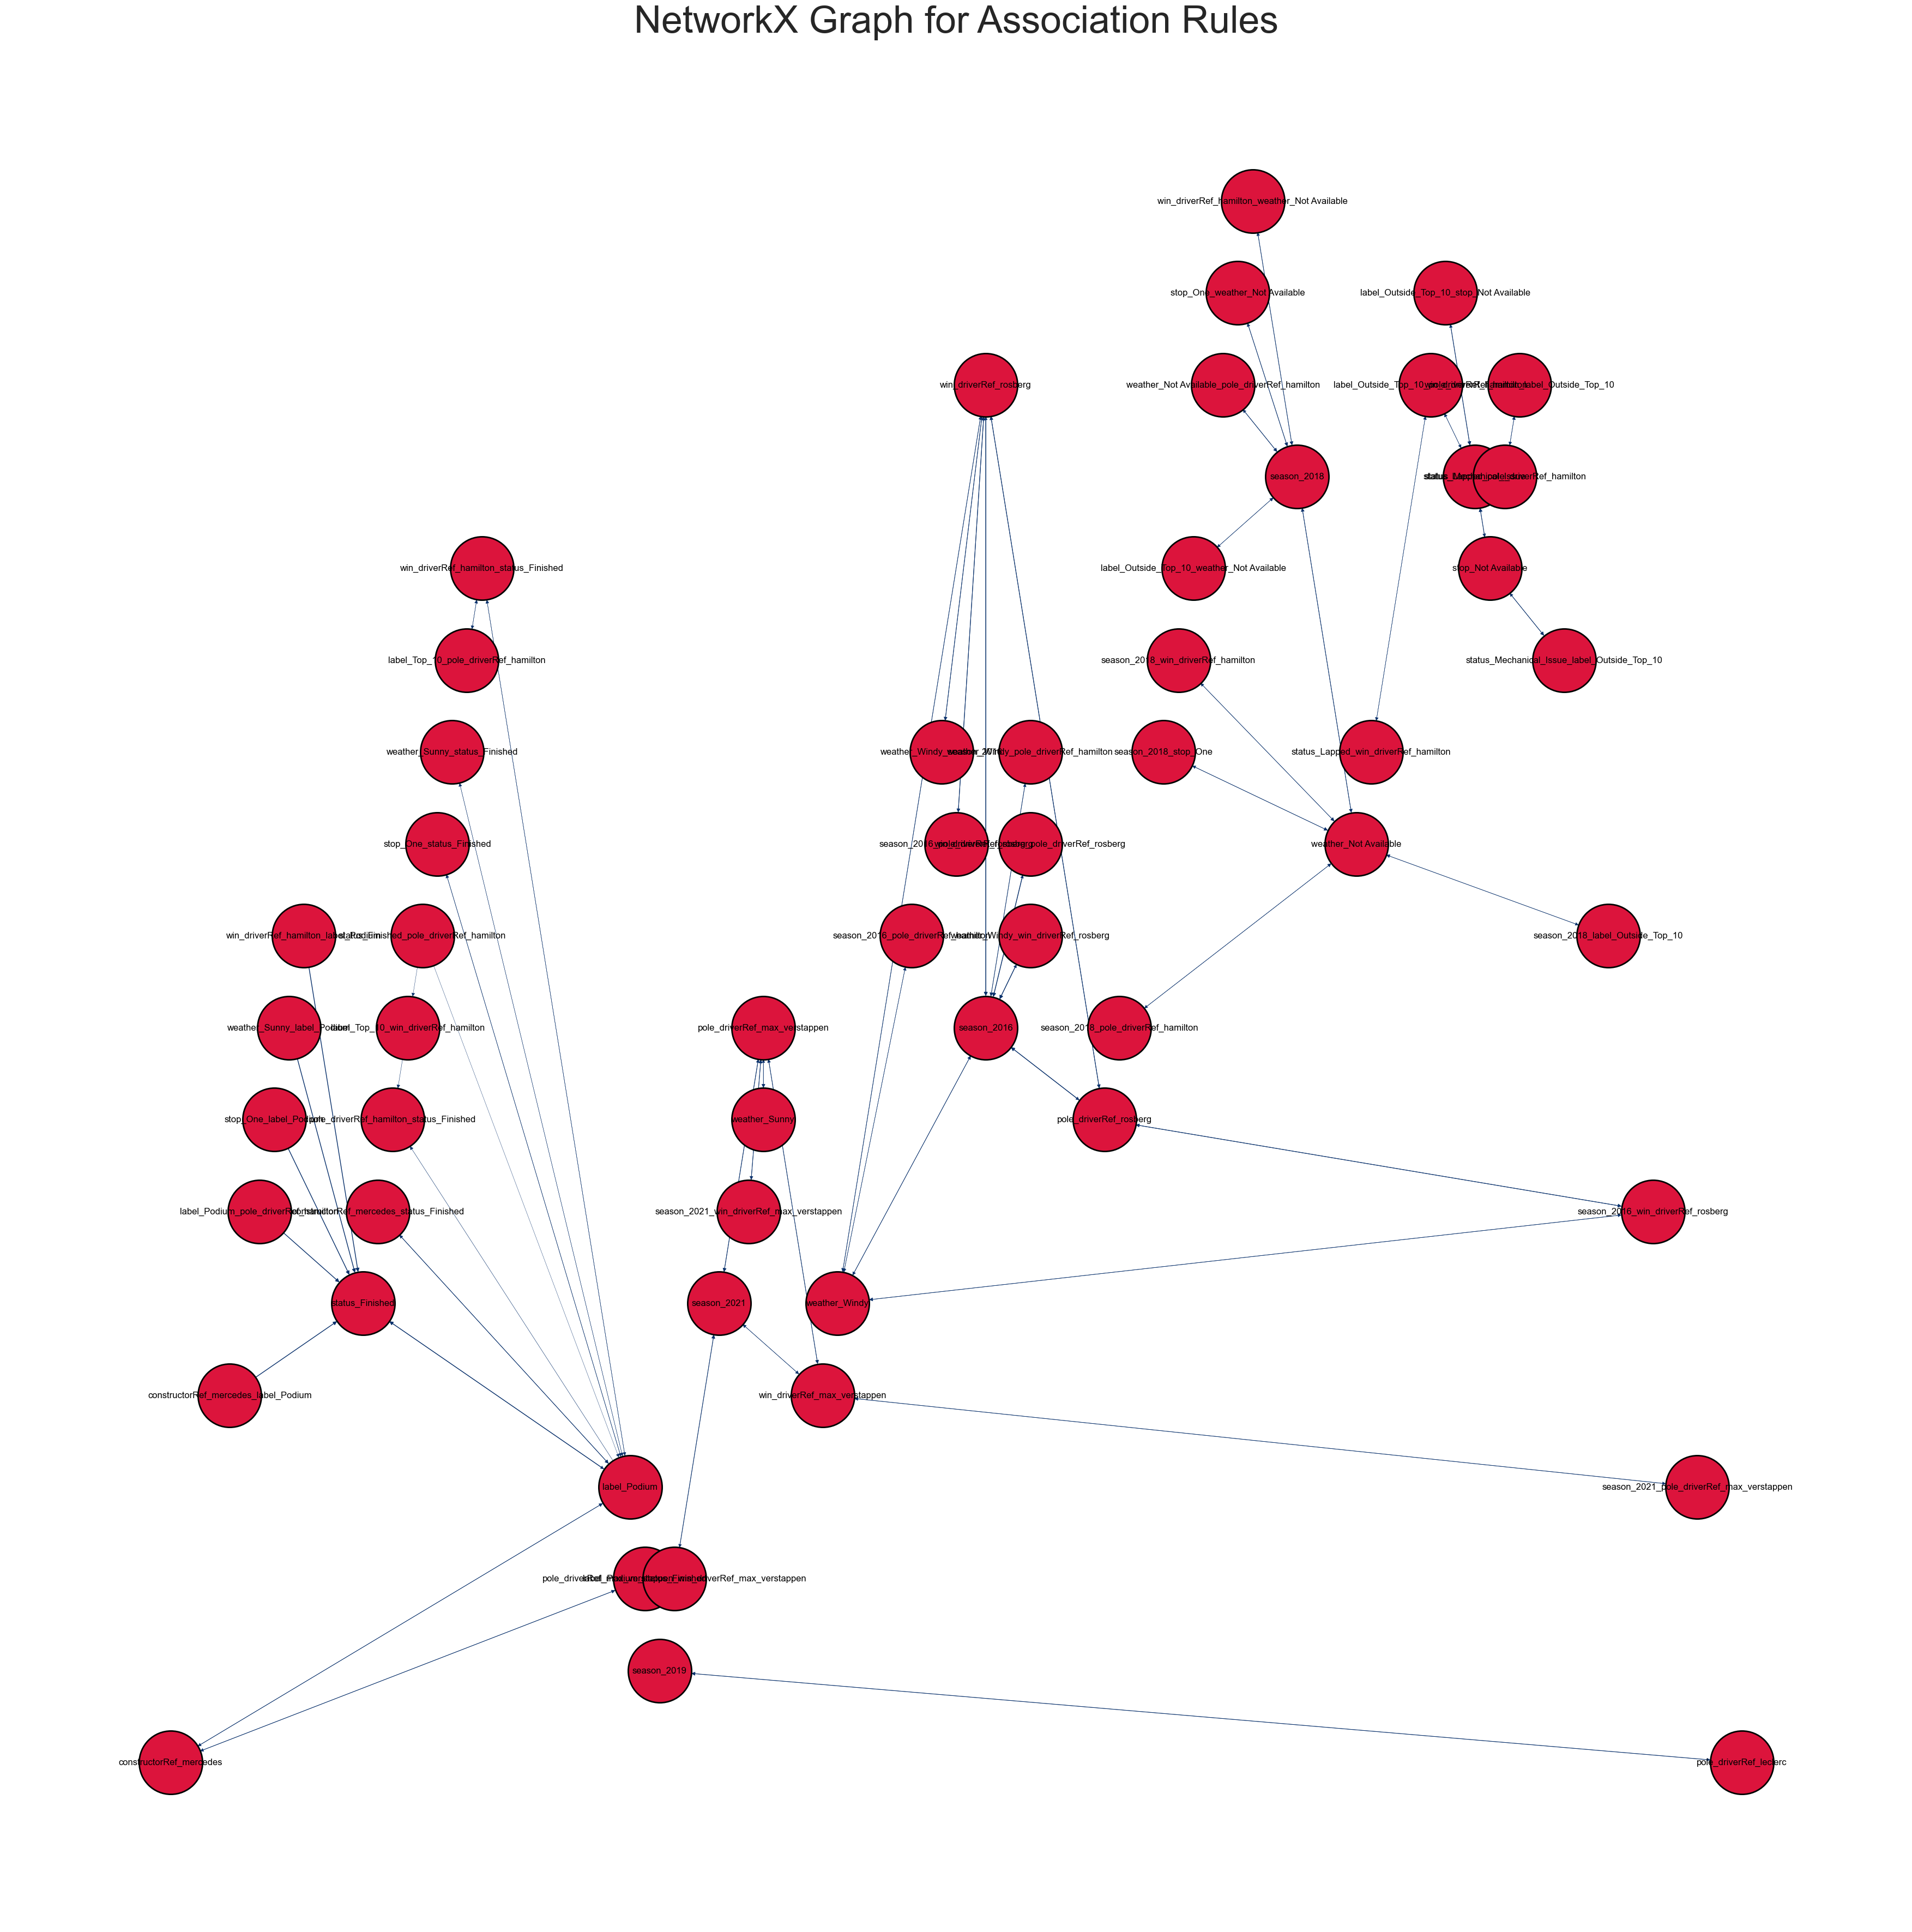

In [180]:
G = convert_to_network(result_df)
plot_network(G)

# Conclusion

- There are a lot of interesting relations from the rules than can be seen from the network graph.
- Suppose if the weather is windy, the season is 2016 and Rosberg is on the pole (1st in the starting grid), it is highly likely that he will get Top 3 (Podium) in the race.
- And if the status of the race is Lapped and Hamilton has won the race, it most likely the position that a driver got is Outside Top 10.
- For the season 2021, if Max Verstappen is on the pole and the weather conditions are Sunny, it is likely that he will win that race.
- There are many more conclusions that can be drawn by seeing the graph.
